In [38]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   

%matplotlib inline

In [2]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [5]:
query = """
SELECT 
    count()
FROM 
    ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df

,count()
0,85207


#### 1. Выгрузить информацию о цене в зависимости от типа жилья

In [6]:
query = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


#### Посчитать 75-й перцентиль цены в зависимости от типа жилья

In [9]:
df.groupby(['room_type'])['price'].quantile(0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [10]:
df.query("room_type =='Private room'").quantile(q=0.75)

price    70.0
Name: 0.75, dtype: float64

#### 2. Построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья.

In [11]:
query = """
SELECT
    room_type,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE review_scores_rating is not NULL
ORDER BY id ASC
LIMIT 1000
"""
df_1 = ph.read_clickhouse(query, connection=connection)
df_1

,room_type,review_scores_rating,price
0,Private room,97.0,65.0
1,Entire home/apt,96.0,100.0
2,Entire home/apt,94.0,300.0
3,Entire home/apt,93.0,65.0
4,Private room,96.0,29.0
...,...,...,...
995,Entire home/apt,100.0,165.0
996,Private room,93.0,99.0
997,Private room,100.0,45.0
998,Private room,88.0,20.0


In [17]:
df_i = df_1.groupby('room_type', as_index=False).mean()
df_i

,room_type,review_scores_rating,price
0,Entire home/apt,93.568787,135.882950
1,Hotel room,92.500000,134.000000
2,Private room,94.766205,54.642437
3,Shared room,90.000000,21.000000


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

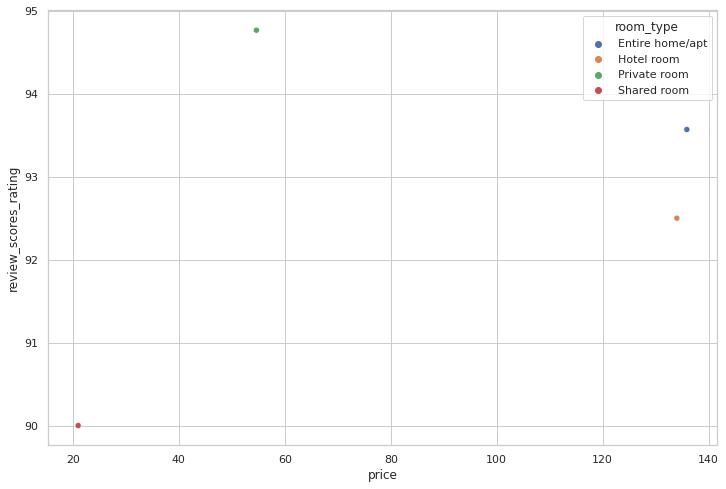

In [43]:
sns.set(style = "whitegrid", rc={'figure.figsize' :(12,8)})
sns.scatterplot(data=df_i, x="price", y="review_scores_rating", hue = "room_type")

#### 3. Определить какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления.

In [31]:
query = """
SELECT
    DISTINCT host_id,
    host_verifications 
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [32]:
df.host_verifications = df.host_verifications.apply(lambda c: c.strip('[]').replace("''","").split(','))

In [33]:
df.host_verifications.explode().value_counts()

 'phone'                    1345
'email'                     1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
'phone'                       16
 'manual_online'              16
 'sent_id'                     6
Name: host_verifications, dtype: int64

#### 4. Определить для скольких объявлений и в каких районах хозяева указали впечатления

In [45]:
query = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(experiences_offered) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [46]:
df = df.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values='experiences_count')
df

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


#### Визуализация результата с помощью тепловой карты

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

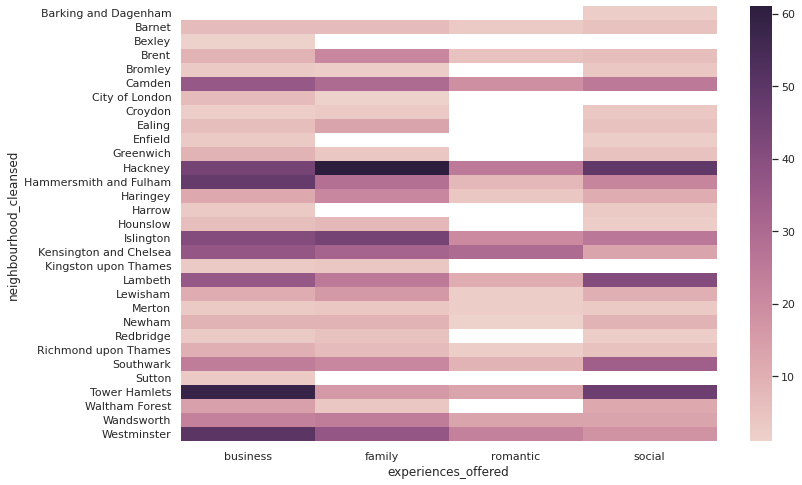

In [47]:
sns.heatmap(df, cmap=sns.cubehelix_palette(as_cmap=True))

#### 5. Выгрузить данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

In [48]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_1 = ph.read_clickhouse(query, connection=connection)
df_1

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


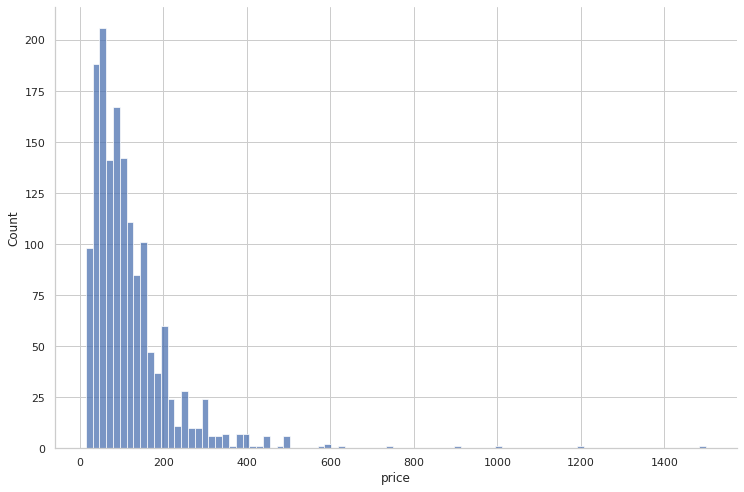

In [49]:
sns.displot(data=df_1, x="price", height=7, aspect=1.5)

In [51]:
import warnings 
warnings.filterwarnings("ignore")

<AxesSubplot:xlabel='price'>

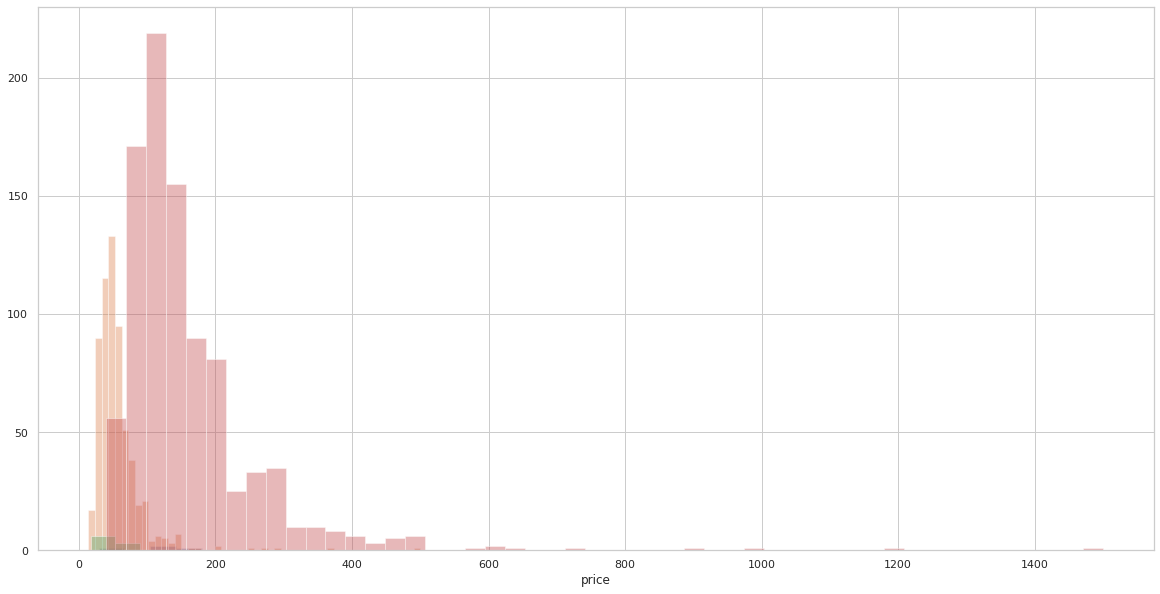

In [57]:
plt.figure(figsize=(20,10))
sns.distplot(df_1.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_1.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_1.query("room_type=='Shared room'").price, kde=False, label='Shared room')
sns.distplot(df_1.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')

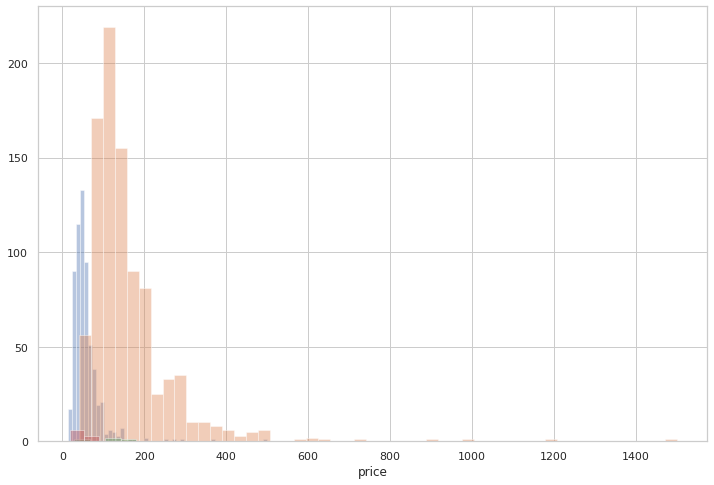

In [54]:
for room in  df_1.room_type.unique():
    sns.distplot(df_1[df_1.room_type == room].price, kde=False) #способ при большом количестве типов комнат

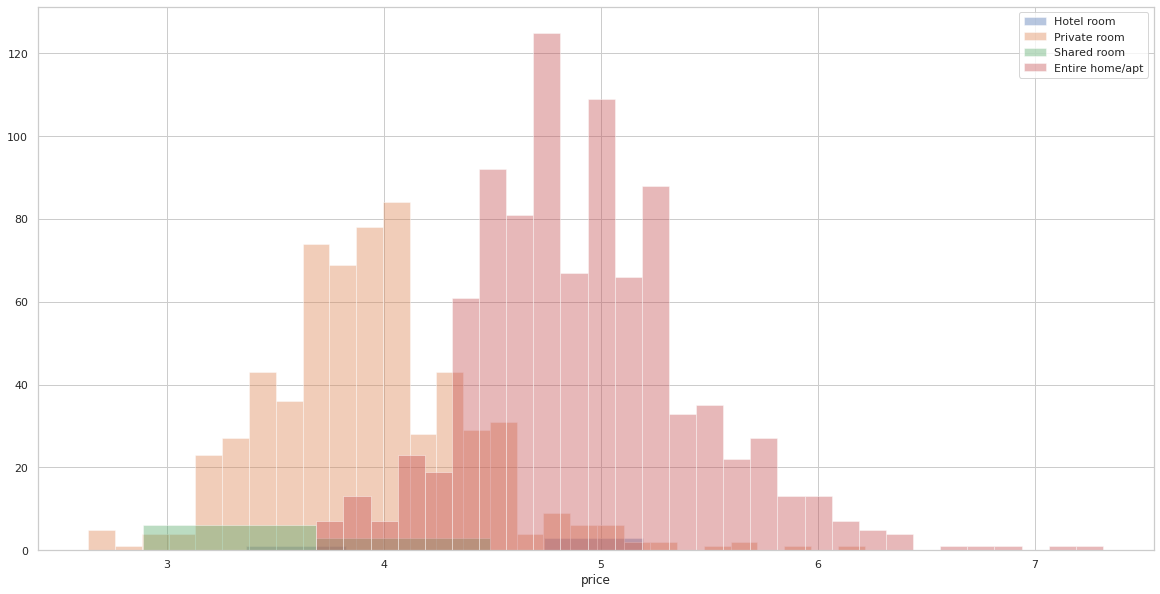

In [55]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_1.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_1.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_1.query("room_type=='Shared room'").price), kde=False, label='Shared room')
sns.distplot(np.log(df_1.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
plt.legend()
plt.show()

#### 6. Выгрузить данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.

In [64]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review 
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [65]:
df.first_review = df.first_review.apply(lambda c: c[:4])

In [66]:
df = df.rename(columns = {'first_review': 'year'})
df

,room_type,price,year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [67]:
df_type= df.groupby(['room_type','year'], as_index=False).price.mean()

<AxesSubplot:xlabel='year', ylabel='price'>

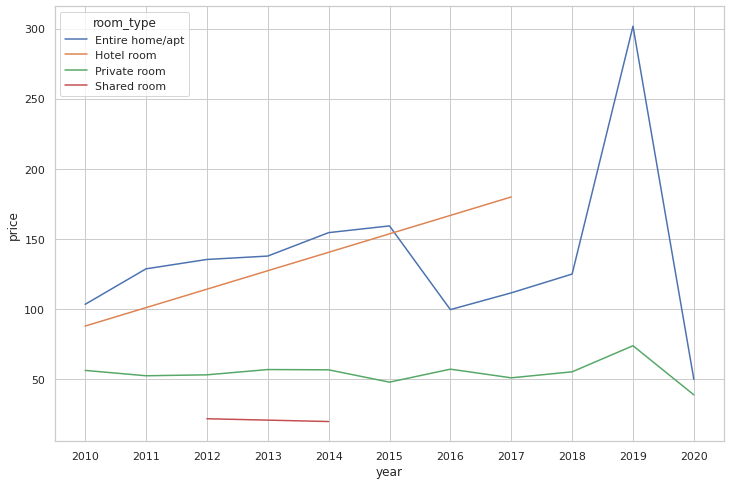

In [69]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='year',y='price',hue='room_type',data=df_type)